In [11]:
# !pip install Spotipy

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import spotipy
from spotipy import SpotifyClientCredentials
from itertools import chain


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Data Collection:

Spotipy API:

- Using the Spotipy API, songs will be collected using the "Top 10,000 Songs of All Time" playlist by Acclaimed Music.
- This playlist was chosen because it has a large range of songs and genres.

Client Authentication:

- In order to interact with the Spotify API, we need client authentification.
- This can be gained by creating an account through the Spotify for developers page.

In [2]:
cid = '05599fed8e1e4a9b9cc649b774b58693'
secret = 'e4c7c4105d894429ae92e859c9c3e9da'

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
spot = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [4]:
#loop through API calls to collect songs (100 at a time)

playlist_link = 'https://open.spotify.com/playlist/1G8IpkZKobrIlXcVPoSIuf?si=f819917d1bca45b8'
playlist_uri = playlist_link.split("/")[-1].split("?")[0]
song_list=[]

for i in range(0,9901,100):
    track_uris = [x["track"]["uri"] for x in spot.playlist_tracks(playlist_uri,limit=100,offset=i)["items"] if x["track"] is not None]
    #Append the songs to list
    song_list.append(track_uris)

In [5]:
#condense the list of lists into a single list
song_list = list(chain.from_iterable(song_list))

Review example data:

- Look at an example song to see its formatting.
- From this we can create a new dataset. This is required because the genres of the songs are not included in the json package that the API returns. Instead, it is held within the artist's URI.
- We will use the artist URI to determine each artist's/song's genre.
- This is limiting because artists may create songs of various genres, but we are restricted to one genre per artist.

Catch Spotipy Mistakes:

- Some song links to the artist page have been deleted.
- This throws errors, so the data needs to filter out these problematic entries.

In [ ]:
artist_uris = []
failed_uris = []
genres = []

In [ ]:
# Test if each song has a valid link to the artist.
# If so, append uri
for i in song_list:
    try:
       artist_uri = spot.track(i)['album']['artists'][0]['uri']
       artist_uris.append(artist_uri)
       genres.append(spot.artist(artist_uri)['genres'][0])
    except:
       failed_uris.append(i)    


Filter URIs:

- The successfully populated URIs need to be filtered from the missing values.

In [ ]:
# Create list of filtered URIs
filtered_uris = [x for x in song_list if x not in failed_uris]

In [ ]:
# Loop through URIs

features = []
more_failed_uris = []

for i in filtered_uris:
   try:
       track_feature = spot.audio_features(i)[0]
       features.append(track_feature)
   except:
       more_failed_uris.append(i)

In [ ]:
# Loop through URIs to extract the successfully gleaned genres

refiltered_genres = []

re_filtered = [ x['uri'] for x in features if x not in failed_uris]
for i in song_list:
    artist_uri = spot.track(i)['album']['artists'][0]['uri'] 
    refiltered_genres.append(spot.artist(artist_uri)['genres'][0])

In [ ]:
# Create a dataframe to include our features and genres
df = pd.DataFrame(data = features, columns = features[0].keys())
gen = pd.Series(refiltered_genres)
df['genre'] = gen.values

Cameron Watts Dataset:

- Because the Spotipy API takes days to run, during testing we leveraged a pre-created dataset that follows the same collection process from Cameron Watts in the article "Extracting Song Data From the Spotify API Using Python"

In [3]:
music_set = pd.read_csv('https://raw.githubusercontent.com/enjuichang/PracticalDataScience-ENCA/main/data/allsong_data.csv')

Exploratory Data Analysis (EDA):

- Review data and features.
- Drop unnecessary features.
- Condense list of genres/sub-genres to common genres.

In [4]:
# Review all of the successfully scraped entries
music_set.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69,"['dance_pop', 'hip_hop', 'hip_pop', 'pop', 'po...",low,Neutral
1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83,"['dance_pop', 'pop', 'post-teen_pop']",low,Neutral
2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25,"['dance_pop', 'pop', 'r&b']",high,Negative
3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79,"['dance_pop', 'pop']",low,Neutral
4,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2,"['pop_rap', 'reggae_fusion']",low,Neutral


Drop unnecessary features:

- We only care about features we can use numerically to fit our models on, so we will drop the track names, artist names, polarities, subjectivities, track popularities, and artist popularities.


In [5]:
# Drop unnecessary features
music_set = music_set.drop(columns=['id',
                                    'artist_name',
                                    'track_name',
                                    'polarity',
                                    'subjectivity',
                                    'track_pop',
                                    'artist_pop',
                                    'genres'])

Condense genre list:

- Condense genre list down to first (main) entry.

In [6]:
# Condense genre list down to first (main) entry
music_set.genres_list = music_set['genres_list'].apply(lambda st: st[st.find("[")+1:st.find(",")])

In [7]:
# Review condense genres
music_set.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres_list
0,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,'dance_pop'
1,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,'dance_pop'
2,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,'dance_pop'
3,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,'dance_pop'
4,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,'pop_rap'


In [8]:
# Create a series of genre counts counts
genre_counts = music_set.genres_list.value_counts()

In [9]:
# Filters genres to those containing more than 500 entries.
# There are a remarkable amount of genres/sub-genres, so this narrows the list appropriately.
new_genres = genre_counts[genre_counts >=500].index 

In [10]:
# Creates new dataframe of only selected features
music_set_filtered = music_set[(music_set['genres_list'] != "'unknown'") & music_set['genres_list'].isin(new_genres) ]
print(music_set_filtered)

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
0             0.904   0.813    4    -7.105     0       0.1210       0.03110   
1             0.774   0.838    5    -3.914     0       0.1140       0.02490   
2             0.664   0.758    2    -6.583     0       0.2100       0.00238   
3             0.892   0.714    4    -6.055     0       0.1410       0.20100   
5             0.881   0.788    2    -4.669     1       0.1680       0.02120   
...             ...     ...  ...       ...   ...          ...           ...   
34215         0.454   0.605    4    -6.816     1       0.0314       0.25500   
34216         0.514   0.742    8    -2.525     1       0.0258       0.27000   
34217         0.483   0.531    8    -5.889     1       0.0304       0.29700   
34218         0.646   0.595    7    -6.275     1       0.0327       0.05450   
34219         0.591   0.553    5    -6.131     1       0.0253       0.27300   

       instrumentalness  liveness  valence    tempo

Modeling:

- Two types of models were tested
   - Logistic Regression
   - Dense Neural Network (DNN)
- These models are created to illustrate base cases for the Spotify data.
- Specifically for the DNN, data needs to be in the correct "shape".
   - DNN: (n, n)
- Data is also split into 3 sets
   - Training set: For the model to train on
   - Validation set: For the model to compare against while training
   - Test set: A set unsees by the model until the end for final testing

In [40]:
# Define features (X) and target (y)
X = music_set_filtered.drop(columns='genres_list')
y = music_set_filtered.genres_list

In [41]:
# One-Hot Encode 'key'
X = pd.get_dummies(columns=['key'], data=X, drop_first=True)

In [43]:
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42, stratify=y_train)

# Print shape
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (3087, 21), y training data shape: (3087,)
X validation data shape: (2058, 21), y validation data shape: (2058,)


In [44]:
def plot_history(hist):
    """Plots the accuracy and loss for a model over the course of all epochs
    
    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

Logistic Regression:

- A simple logistic regression model was constructed using no penalty and a 'lbfgs' solver.
- Max iterations were increased to allow the model to converge.

In [45]:
# Instantiate Logistic Regression Model
logreg = LogisticRegression(penalty=None, solver= 'lbfgs', max_iter=10000, random_state=42)

In [46]:
# Fit model
logreg.fit(X_train, y_train)

c:\Users\botla\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=10000, penalty=None, random_state=42)

In [47]:
# Review model performance
print(" Logistic Regression ".center(30, "-"))
print(f'Training Accuracy:    {round(logreg.score(X_train, y_train), 5)}')
print(f'Validation Accuracy:  {round(logreg.score(X_val, y_val), 5)}')
print(f'Testing Accuracy:     {round(logreg.score(X_test, y_test), 5)}')

---- Logistic Regression -----
Training Accuracy:    0.56041
Validation Accuracy:  0.55588
Testing Accuracy:     0.53978


### Dense Neural Network (DNN)

- A Dense Neural Network consists of multiple dense layers ordered sequentially one after the other.
- An 'l2' regularization penalty was leveraged to help mitigate overfitting.
- Dropout layers were included to help mitigate overfitting.
- Early stopping was utilized to stop fitting the model once validation accuracy plateaued

In [48]:
# Encode data for Dense Neural Network
le = LabelEncoder()

encoded_y_train = le.fit_transform(y_train)
encoded_y_val = le.transform(y_val)
encoded_y_test = le.transform(y_test)

In [49]:
# Dense Neural Network

# Instantiate sequential model
model_dnn = Sequential()

# Create Dense Layers
model_dnn.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.1))
model_dnn.add(Dense(64, activation='relu'))

# output to 8 classes for predictions
model_dnn.add(Dense(8, activation='softmax'))

c:\Users\botla\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
# Review model structure
model_dnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,304 (184.78 KB)

 Trainable params: 47,304 (184.78 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Compile
model_dnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [52]:
# Create an early stopping callback
es = EarlyStopping(monitor='val_loss', patience=15, min_delta=0) 

In [53]:
# Train the model
hist = model_dnn.fit(
    X_train, encoded_y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_val, encoded_y_val),
    verbose=1,
    callbacks=[es]
)

Epoch 1/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.1588 - loss: 7.0899 - val_acc: 0.0957 - val_loss: 2.2732
Epoch 2/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.2003 - loss: 2.4770 - val_acc: 0.2556 - val_loss: 2.1091
Epoch 3/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.2338 - loss: 2.2501 - val_acc: 0.2522 - val_loss: 2.0760
Epoch 4/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.2360 - loss: 2.1723 - val_acc: 0.3027 - val_loss: 2.0299
Epoch 5/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.2629 - loss: 2.1045 - val_acc: 0.3275 - val_loss: 2.0007
Epoch 6/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.3018 - loss: 2.0787 - val_acc: 0.3173 - val_loss: 1.9975
Epoch 7/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.2779 - loss: 2.0500 - val_acc: 0.3163 - val_loss: 1.9847
Epoch 8/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.3045 - loss: 2.0057 - val_acc: 0.3280 - val_loss: 1.9511
Epoch 9/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

In [54]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, encoded_y_test)
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5203 - loss: 1.3835
Test Loss: 1.3919618129730225
Test Accuracy: 0.5056834816932678


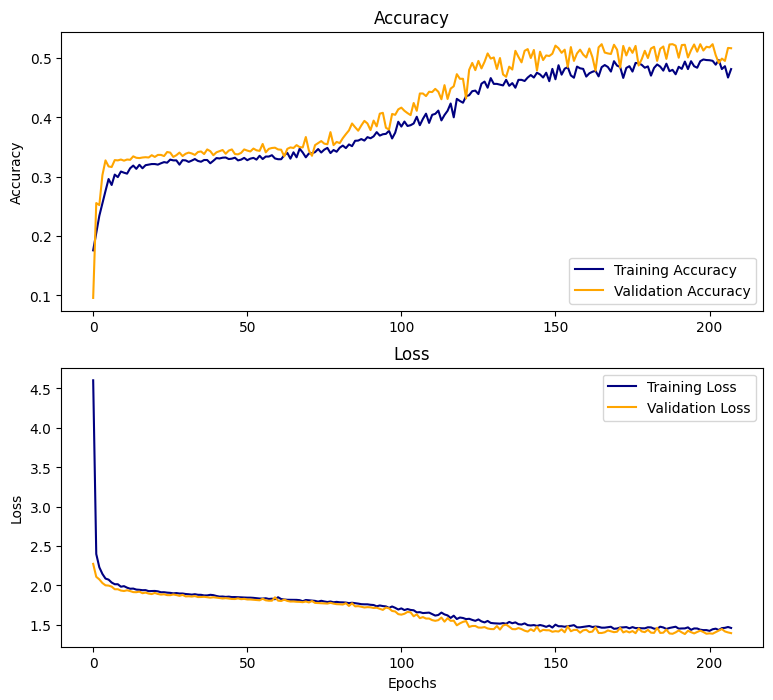

In [55]:
plot_history(hist)

### Model Performance Summary
Below are the final performance metrics for both models that were tested on the tabular audio feature data.


| **Model**                                      | **Accuracy** |
|------------------------------------------------|--------------|
|  Logistic Regression                   | 0.5397  |
| Dense Neural Network (DNN)| 0.505 |

## Conclusions

Spotify Tabular Audio Data Summary:

- In this notebook we reviewed tabular audio feature data from Spotify's web API.
- We processed the data to be the correct format to train both logistic regression and dense neural network models.
- With further iteration, these models could be improved. However, using this tabular data requires music preprocessing to find the features used for fitting, which takes time and resources.
- Additionally, during this process the genre itself could be surmised during preprocessing.
- This study will be used to compare the neural networks that process raw audio data in the other notebooks.



In [58]:
import joblib

model_dnn.save('models/spotify_model_dnn.h5')
joblib.dump(logreg, 'models/logistic_spotify_model.pkl')

['models/logistic_spotify_model.pkl']

In [62]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('models/model_cnn1.h5')

In [64]:
import joblib

# Load the model
model = joblib.load('models/logistic_spotify_model.pkl')

In [65]:
# Example feature dictionary (adjust based on your X_train.columns)
input_data = {
    'danceability': 0.7,
    'energy': 0.8,
    'loudness': -5.0,
    'speechiness': 0.1,
    'acousticness': 0.2,
    'instrumentalness': 0.0,
    'liveness': 0.3,
    'valence': 0.6,
    'tempo': 120.0,
    'duration_ms': 200000,
    'time_signature': 4,
    'mode': 1,
    'key': 5  # Example: key = 5 (F)
}
input_df = pd.DataFrame([input_data])

In [67]:
# One-hot encode the 'key' column
input_df = pd.get_dummies(columns=['key'], data=input_df, drop_first=True)

In [68]:
# Get the expected columns from training (example, replace with actual X_train.columns)
expected_columns = X_train.columns  # You need to know this from training
for col in expected_columns:
    if col not in input_df.columns:
        input_df[col] = 0
# Reorder columns to match X_train
input_df = input_df[expected_columns]

In [69]:
# Convert to numpy array
input_array = input_df.to_numpy()
# Predict
prediction = model.predict(input_array)
print("Predicted Genre:", prediction[0])
# Predict probabilities (optional)
probabilities = model.predict_proba(input_array)
print("Class Probabilities:", probabilities[0])

Predicted Genre: 'dance_pop'
Class Probabilities: [0.00983089 0.02485452 0.08950557 0.02883832 0.04538593 0.0974257
 0.04325468 0.66090439]


c:\Users\botla\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\botla\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
